In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [285]:
class LiveDeathClassifier(nn.Module):
    def __init__(self, num_features=19, h1=30, h2=30, h3=20, features=2) -> None:
        super(LiveDeathClassifier, self).__init__()
        self.fc1 = nn.Linear(num_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [383]:
main = pd.read_csv('../data/cleaned_train.csv')
main['Class'] = main['Class'].map(lambda x : 1 if x == 'DIE' else 0)
main

,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,AGE,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,Class,OneHotSex
0,1,0,1,1,0,0,1,0,1,1,1,0,0.661290,0.584416,0.411504,0.541667,0.18750,0.31,1,1.0
1,0,0,1,0,0,0,1,1,1,0,1,0,0.709677,0.090909,0.333702,0.022727,0.28125,0.63,0,1.0
2,1,0,1,0,0,0,1,0,0,0,0,1,0.532258,0.038961,0.141593,0.575758,0.59375,0.63,0,1.0
3,0,0,1,0,0,1,1,1,1,1,1,0,0.290323,0.129870,0.668142,0.632576,0.75000,0.57,0,1.0
4,1,0,1,0,0,1,1,0,1,0,0,1,0.435484,0.090909,0.185841,0.121212,0.71875,0.57,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0,0,1,1,1,0,0,1,0,0,0,1,0.258065,0.129870,0.725664,0.515152,0.62500,0.90,0,1.0
98,1,0,0,0,0,0,1,0,0,0,0,0,0.500000,0.012987,0.942478,0.132576,0.53125,0.90,1,1.0
99,1,0,0,0,0,0,0,1,0,0,0,1,0.467742,0.064935,0.243363,0.113636,0.65625,0.85,0,1.0
100,1,1,1,1,0,0,0,0,0,0,0,1,0.403226,0.090909,0.110619,0.117424,0.62500,0.56,0,1.0


In [384]:
X = main.copy()

for col in ['Class']:
    if col in main.columns:
        X = X.drop(col, axis=1)

y=main[['Class']]

In [288]:
from imblearn.over_sampling import RandomOverSampler

# resample the X_train and y_train data
ros = RandomOverSampler(random_state=69)

# for now, ros is only applied on the train data
X, y = ros.fit_resample(X, y)

X.shape, y.shape

((162, 19), (162, 1))

In [289]:
X = X.values
y = y.values

In [290]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69, shuffle=True)

In [291]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [292]:
y_train = torch.LongTensor(y_train).squeeze()
y_test = torch.LongTensor(y_test).squeeze()

In [293]:
y_test.shape

torch.Size([33])

In [294]:
X_train.shape

torch.Size([129, 19])

In [325]:
epochs = 40
losses, eval_losses = [], []

model = LiveDeathClassifier()
criterion = nn.CrossEntropyLoss()
optimzer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
    
    with torch.no_grad():
        model.eval()
        y_eval = model.forward(X_test)
        loss_eval = criterion(y_eval, y_test)
        eval_losses.append(loss_eval.detach().numpy())
    
    print(f"Epoch : {i+1} and loss {loss} and eval {loss_eval}")



Epoch : 1 and loss 0.6945039629936218 and eval 0.6824457049369812
Epoch : 2 and loss 0.6756431460380554 and eval 0.6608999371528625
Epoch : 3 and loss 0.6514252424240112 and eval 0.631446361541748
Epoch : 4 and loss 0.6202691793441772 and eval 0.5912861824035645
Epoch : 5 and loss 0.5801475644111633 and eval 0.5422453284263611
Epoch : 6 and loss 0.535758376121521 and eval 0.48349514603614807
Epoch : 7 and loss 0.49161577224731445 and eval 0.4174370765686035
Epoch : 8 and loss 0.45211926102638245 and eval 0.35482150316238403
Epoch : 9 and loss 0.41697996854782104 and eval 0.3067924380302429
Epoch : 10 and loss 0.3875637948513031 and eval 0.27242833375930786
Epoch : 11 and loss 0.36254963278770447 and eval 0.2482493370771408
Epoch : 12 and loss 0.3420844078063965 and eval 0.22565262019634247
Epoch : 13 and loss 0.32435762882232666 and eval 0.20679038763046265
Epoch : 14 and loss 0.3114980459213257 and eval 0.19102351367473602
Epoch : 15 and loss 0.29781079292297363 and eval 0.18048058450

<Axes: >

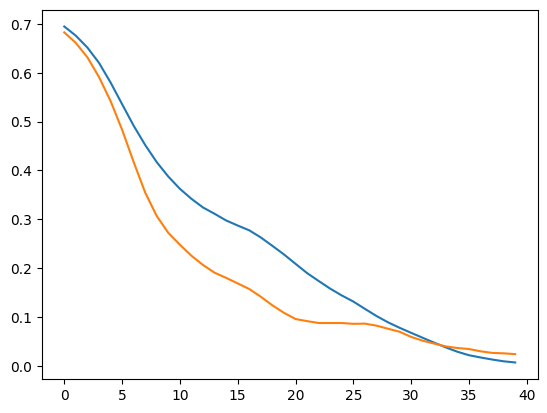

In [326]:
losses = [float(x) for x in losses]
losses_val = [float(x) for x in eval_losses]

sns.lineplot(losses)
sns.lineplot(losses_val)

In [331]:
with torch.no_grad():
    model.eval()
    for i, data in enumerate(X_test):
        y_pred = model.forward(data)

        print(f'{i+1} : {str(y_pred)}   {y_pred.argmax().item()}  {y_test[i]}')


1 : tensor([ 0.6405, -0.1181])   0  0
2 : tensor([ 6.3112, -4.0988])   0  0
3 : tensor([-3.5889,  3.4980])   1  1
4 : tensor([-3.5597,  3.3872])   1  1
5 : tensor([ 7.0469, -4.5774])   0  0
6 : tensor([ 6.3484, -4.0990])   0  0
7 : tensor([ 6.4082, -4.0737])   0  0
8 : tensor([-2.0295,  2.1403])   1  1
9 : tensor([ 4.5916, -3.0290])   0  0
10 : tensor([ 3.3150, -1.6590])   0  0
11 : tensor([-6.8304,  5.7301])   1  1
12 : tensor([-7.2998,  6.1310])   1  1
13 : tensor([ 5.0999, -3.3274])   0  0
14 : tensor([-3.7885,  3.7026])   1  1
15 : tensor([-4.1442,  3.9682])   1  1
16 : tensor([ 0.9277, -0.0711])   0  0
17 : tensor([-4.1442,  3.9682])   1  1
18 : tensor([-3.5597,  3.3872])   1  1
19 : tensor([ 4.8871, -3.1951])   0  0
20 : tensor([ 2.9109, -1.5380])   0  0
21 : tensor([ 5.0378, -3.2923])   0  0
22 : tensor([-6.1306,  5.3167])   1  1
23 : tensor([ 2.5774, -1.7290])   0  0
24 : tensor([ 2.9110, -1.4851])   0  0
25 : tensor([-4.2215,  3.9075])   1  1
26 : tensor([ 4.2038, -2.7495])   

In [337]:
test = pd.read_csv('../data/cleaned_test.csv')

In [392]:
test_tens = torch.LongTensor(test.values).squeeze().float()
test_tens

tensor([[0., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        [1., 1., 0.,  ..., 0., 0., 1.]])

In [393]:
list = []

with torch.no_grad():
    model.eval()
    for i, data in enumerate(test_tens):
        y_pred = model.forward(data)

        list.append(y_pred.argmax().item())

In [399]:
final = pd.DataFrame({"Class":list})
final

final['Class'] = final['Class'].apply(lambda x : 'DIE' if x == 1 else 'LIVE')
final.value_counts()

Class
DIE      38
LIVE     15
Name: count, dtype: int64

In [ ]:
csv = pd.read_csv('../Alina/group_7.csv')
csv.shape

In [366]:
final.shape

(33, 1)

In [396]:
final.to_csv('group_7-2.csv', index=False)